# Notebook Styling: Please do not edit

In [2]:
#import os
#os.system ("pip install keras==2.4.3")

!pip install tensorflow

import keras

print('The keras version is {}.'.format(keras.__version__))

Defaulting to user installation because normal site-packages is not writeable
The keras version is 2.13.1.


In [3]:
# IPython display functions
import IPython
from IPython.display import display, HTML, SVG, Image

# General Plotting
import matplotlib.pyplot as plt

plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = [10, 6] ## plot size
plt.rcParams['axes.linewidth'] = 2.0 #set the value globally

## notebook style and settings
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_png { display: table-cell; text-align: center; vertical-align: middle; } </style>"))
display(HTML("<style>.MathJax {font-size: 100%;}</style>"))

# For changing background color
def set_background(color):
    script = ( "var cell = this.closest('.code_cell');" "var editor = cell.querySelector('.input_area');" "editor.style.background='{}';" "this.parentNode.removeChild(this)" ).format(color)
    display(HTML('<img src onerror="{}">'.format(script)))

/tmp/ipykernel_438/3485464767.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


Library Imports

In [4]:
import os
import sys
import random
import numpy as np
import pandas as pd
from os import walk

# Metrics
from sklearn.metrics import *

# Keras library for deep learning
# https://keras.io/
import tensorflow as tf
import keras
from keras.datasets import mnist # MNIST Data set
from keras.models import Sequential # Model building
from keras.layers import * # Model layers
from keras.preprocessing.image import *
from tensorflow.keras.utils import *
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

tf.keras.utils.set_random_seed(568)

# 1. Helper Functions

## 1.1 Confusion Matrix
Confusion matrices are an important toolkit in every data scientist's box. We have created a function for you that you can use to create visual confusion matrices and analyze your models.

In [5]:
def displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, title):
    # Set font size for the plots. You can ignore this line.
    PLOT_FONT_SIZE = 14
    
    # Set plot size. Please ignore this line
    plt.rcParams['figure.figsize'] = [5, 5]
    
    # Transpose of confusion matrix to align the plot with the actual precision recall values. Please ignore this as well.
    confusionMatrix = np.transpose(confusionMatrix)
    
    # Plotting the confusion matrix
    plt.imshow(confusionMatrix, interpolation='nearest',cmap=plt.cm.Blues, vmin=0, vmax=100)
    
    
    # Setting plot properties. You should ignore everything from here on.
    xticks = np.array([-0.5, 0, 1,1.5])
    plt.gca().set_xticks(xticks)
    plt.gca().set_yticks(xticks)
    plt.gca().set_xticklabels(["", "Healthy\nRecall=" + str(recallNegative) , "Pneumonia\nRecall=" + str(recallPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.gca().set_yticklabels(["", "Healthy\nPrecision=" + str(precisionNegative) , "Pneumonia\nPrecision=" + str(precisionPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.ylabel("Predicted Class", fontsize=PLOT_FONT_SIZE)
    plt.xlabel("Actual Class", fontsize=PLOT_FONT_SIZE)
    plt.title(title, fontsize=PLOT_FONT_SIZE)
        
    # Add text in heatmap boxes
    for i in range(2):
        for j in range(2):
            text = plt.text(j, i, confusionMatrix[i][j], ha="center", va="center", color="white", size=15) ### size here is the size of text inside a single box in the heatmap
            
    plt.show()

In [6]:
def calculateMetrics(predictions, predictionsProbabilities, actualLabels):
    # Convert label format from [0,1](label 1) and [1,0](label 0) into single integers: 1 and 0.
    actualLabels = [item[1] for item in actualLabels]
    
    # Get probabilities for the class with label 1. That is all we need to compute AUCs. We don't need probabilities for class 0.
    predictionsProbabilities = [item[1] for item in predictionsProbabilities]
    
    # Calculate metrics using scikit-learn functions. The round function is used to round the numbers up to 2 decimal points.
    try:
        accuracy = round(accuracy_score(actualLabels, predictions) * 100, 2)
        precisionNegative = round(precision_score(actualLabels, predictions, average = None)[0] * 100, 2)
        precisionPositive = round(precision_score(actualLabels, predictions, average = None)[1] * 100, 2)
        recallNegative = round(recall_score(actualLabels, predictions, average = None)[0] * 100, 2)
        recallPositive = round(recall_score(actualLabels, predictions, average = None)[1] * 100, 2)
    except:
        print("An exception occurred but was caught.")
    auc = round(roc_auc_score(actualLabels, predictionsProbabilities) * 100, 2)
    
    return auc

## 1.2 Metrics Calculation
We are giving you a function that will calculate all the metrics you'll need in order to analyze your model

In [7]:
def calculateMetricsAndPrint(predictions, predictionsProbabilities, actualLabels):
    # Convert label format from [0,1](label 1) and [1,0](label 0) into single integers: 1 and 0.
    actualLabels = [item[1] for item in actualLabels]
    
    # Get probabilities for the class with label 1. That is all we need to compute AUCs. We don't need probabilities for class 0.
    predictionsProbabilities = [item[1] for item in predictionsProbabilities]
    
    # Calculate metrics using scikit-learn functions. The round function is used to round the numbers up to 2 decimal points.
    accuracy = round(accuracy_score(actualLabels, predictions) * 100, 2)
    precisionNegative = round(precision_score(actualLabels, predictions, average = None)[0] * 100, 2)
    precisionPositive = round(precision_score(actualLabels, predictions, average = None)[1] * 100, 2)
    recallNegative = round(recall_score(actualLabels, predictions, average = None)[0] * 100, 2)
    recallPositive = round(recall_score(actualLabels, predictions, average = None)[1] * 100, 2)
    auc = round(roc_auc_score(actualLabels, predictionsProbabilities) * 100, 2)
    confusionMatrix = confusion_matrix(actualLabels, predictions)
    
    # Print metrics. .%2f prints a number upto 2 decimal points only.
    print("------------------------------------------------------------------------")
    print("Accuracy: %.2f\nPrecisionNegative: %.2f\nPrecisionPositive: %.2f\nRecallNegative: %.2f\nRecallPositive: %.2f\nAUC Score: %.2f" % 
          (accuracy, precisionNegative, precisionPositive, recallNegative, recallPositive, auc))
    print("------------------------------------------------------------------------")
    
    print("+ Printing confusion matrix...\n")
    # Display confusion matrix
    displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, "Confusion Matrix")
    
    print("+ Printing ROC curve...\n")
    # ROC Curve
    plt.rcParams['figure.figsize'] = [16, 8]
    FONT_SIZE = 16
    falsePositiveRateDt, truePositiveRateDt, _ = roc_curve(actualLabels, predictionsProbabilities)
    plt.plot(falsePositiveRateDt, truePositiveRateDt, linewidth = 5, color='black')
    plt.xticks(fontsize=FONT_SIZE)
    plt.yticks(fontsize=FONT_SIZE)
    plt.xlabel("False Positive Rate", fontsize=FONT_SIZE)
    plt.ylabel("True Positive Rate", fontsize=FONT_SIZE)
    plt.show()
    
    return auc

## 1.3 Kaggle Predictions

In [8]:
def getKagglePredictions(model, kaggleData, filename):
    print("+ Writing kaggle test results in : results/%s..." % filename)
    predictions = model.predict(kaggleData)
    predictionProbs = [item[1] for item in predictions]
        
    # Store predictions for kaggle
    outputFile = open("results/" + str(filename), "w")
    outputFile.write("Id,Prediction\n")
    for i in range(0, len(predictionProbs)):
        outputFile.write(str(i + 1) + "," + str(predictionProbs[i]) + "\n")
    
    outputFile.close()

## 1.4 Top n% accuracy

In [9]:
def calculateClasswiseTopNAccuracy(actualLabels, predictionsProbs, TOP_N):
    """
    TOP_N is the top n% predictions you want to use for each class
    """

    discreteActualLabels = [1 if item[1] > item[0] else 0 for item in actualLabels]
    discretePredictions = [1 if item[1] > item[0] else 0 for item in predictionsProbs]
    predictionProbsTopNHealthy, predictionProbsTopNPneumonia = [item[0] for item in predictionsProbs], [item[1] for item in predictionsProbs]
    predictionProbsTopNHealthy = list(reversed(sorted(predictionProbsTopNHealthy)))[:int(len(predictionProbsTopNHealthy) * TOP_N / 100)][-1]
    predictionProbsTopNPneumonia = list(reversed(sorted(predictionProbsTopNPneumonia)))[:int(len(predictionProbsTopNPneumonia) * TOP_N / 100)][-1]

    # Calculate accuracy for both classes
    accuracyHealthy = []
    accuracyPneumonia = []
    for i in range(0, len(discretePredictions)):
        if discretePredictions[i] == 1:
            # Pneumonia
            if predictionsProbs[i][1] > predictionProbsTopNPneumonia:
                accuracyPneumonia.append(int(discreteActualLabels[i]) == 1)
        else:
            # Healthy
            if predictionsProbs[i][0] > predictionProbsTopNHealthy:
                accuracyHealthy.append(int(discreteActualLabels[i]) == 0)

    accuracyHealthy = round((accuracyHealthy.count(True) * 100) / len(accuracyHealthy), 2)
    accuracyPneumonia = round((accuracyPneumonia.count(True) * 100) / len(accuracyPneumonia), 2)
    return accuracyHealthy, accuracyPneumonia

# 2. Data Loading
## 2.1 Loading File Paths
We will first load file paths from normal and pneumonia folders in the train directory.

In [10]:
# Load normal images
normalImagesPath = "data/train/normal"
normalImageFiles = []
for(_,_,files) in walk(normalImagesPath):
    normalImageFiles.extend(files)

normalImagesPath2 = "data/train/normal2"
for(_,_,files) in walk(normalImagesPath2):
    normalImageFiles.extend(files)

print(len(normalImageFiles))

# Load pneumonia images
pneumoniaImagesPath = "data/train/pneumonia"
pneumoniaImageFiles = []
for(_,_,files) in walk(pneumoniaImagesPath):
    pneumoniaImageFiles.extend(files)
    
random.shuffle(pneumoniaImageFiles)
pneumoniaImageFiles = pneumoniaImageFiles[:len(normalImageFiles)]
print("Normal X-ray images: %d\nPneumonia X-ray images: %d" % (len(normalImageFiles), len(pneumoniaImageFiles)))

1436
Normal X-ray images: 1436
Pneumonia X-ray images: 1436


## 2.2 Loading Image Data
### 2.2.1 Training and Validation

In [11]:
imagesData = []
imagesLabels = []

for file in normalImageFiles:
    fullPath = normalImagesPath + "/" + file
    if os.path.exists(fullPath) == False:
        fullPath = normalImagesPath2 + "/" + file
        if os.path.exists(fullPath) == False:
            continue
    imageData = load_img(fullPath, color_mode = "grayscale") # load_img function comes from keras library when we do "from keras.preprocessing.image import *"
    imageArray = img_to_array(imageData) / 255.0
    
    imagesData.append(imageArray)
    imagesLabels.append(0)
    

for file in pneumoniaImageFiles:
    fullPath = pneumoniaImagesPath + "/" + file
    if os.path.exists(fullPath) == False:
            continue
            
    imageData = load_img(pneumoniaImagesPath + "/" + file, color_mode = "grayscale") # load_img function comes from keras library when we do "from keras.preprocessing.image import *"
    imageArray = img_to_array(imageData) / 255.0
    
    imagesData.append(imageArray)
    imagesLabels.append(1)

imagesData = np.array(imagesData)
imagesLabels = keras.utils.to_categorical(imagesLabels)
print("Input data shape: %s" % (imagesData.shape,))

Input data shape: (2860, 256, 256, 1)


In [12]:
"""
from zipfile import ZipFile
file_name = "data/test.zip"

# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall("data/") 
    print('Done!')
"""

'\nfrom zipfile import ZipFile\nfile_name = "data/test.zip"\n\n# opening the zip file in READ mode \nwith ZipFile(file_name, \'r\') as zip: \n    # printing all the contents of the zip file \n    zip.printdir() \n  \n    # extracting all the files \n    print(\'Extracting all the files now...\') \n    zip.extractall("data/") \n    print(\'Done!\')\n'

### Running Basic Models

In [20]:
flat_images = [image.flatten() for image in imagesData]

In [21]:
df = pd.DataFrame(flat_images)

In [23]:
df['class_0'] = [label[0] for label in imagesLabels]
df['class_1'] = [label[1] for label in imagesLabels]


In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier  # Import Decision Tree
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report


X = df.drop(columns=['class_0', 'class_1'])  
y = df['class_1']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Model 
dtrain = xgb.DMatrix(X_train, label=y_train.values)
dtest = xgb.DMatrix(X_test, label=y_test.values)

params = {
    'objective': 'binary:logistic',  # binary classification
    'eval_metric': 'logloss',  # log loss for binary classification
    'max_depth': 5,
    'eta': 0.05
}

xgb_model = xgb.train(params, dtrain, num_boost_round=100)

xgb_preds_proba = xgb_model.predict(dtest)  
xgb_preds_binary = (xgb_preds_proba > 0.5).astype(int)  

xgb_accuracy = accuracy_score(y_test, xgb_preds_binary)
xgb_auc = roc_auc_score(y_test, xgb_preds_proba)
xgb_precision = precision_score(y_test, xgb_preds_binary)
xgb_recall = recall_score(y_test, xgb_preds_binary)
xgb_conf_matrix = confusion_matrix(y_test, xgb_preds_binary)


print(f'XGBoost Binary Accuracy: {xgb_accuracy:.4f}')
print(f'XGBoost AUC: {xgb_auc:.4f}')
print(f'XGBoost Precision: {xgb_precision:.4f}')
print(f'XGBoost Recall: {xgb_recall:.4f}')
print('XGBoost Confusion Matrix:')
print(xgb_conf_matrix)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)  

rf_preds_proba = rf_model.predict_proba(X_test)[:, 1]  
rf_preds_binary = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_preds_binary)
rf_auc = roc_auc_score(y_test, rf_preds_proba)
rf_precision = precision_score(y_test, rf_preds_binary)
rf_recall = recall_score(y_test, rf_preds_binary)
rf_conf_matrix = confusion_matrix(y_test, rf_preds_binary)

print(f'Random Forest Binary Accuracy: {rf_accuracy:.4f}')
print(f'Random Forest AUC: {rf_auc:.4f}')
print(f'Random Forest Precision: {rf_precision:.4f}')
print(f'Random Forest Recall: {rf_recall:.4f}')
print('Random Forest Confusion Matrix:')
print(rf_conf_matrix)

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)  

dt_preds_proba = dt_model.predict_proba(X_test)[:, 1]  # Get probabilities for class 1
dt_preds_binary = dt_model.predict(X_test)

dt_accuracy = accuracy_score(y_test, dt_preds_binary)
dt_auc = roc_auc_score(y_test, dt_preds_proba)
dt_precision = precision_score(y_test, dt_preds_binary)
dt_recall = recall_score(y_test, dt_preds_binary)
dt_conf_matrix = confusion_matrix(y_test, dt_preds_binary)

print(f'Decision Tree Binary Accuracy: {dt_accuracy:.4f}')
print(f'Decision Tree AUC: {dt_auc:.4f}')
print(f'Decision Tree Precision: {dt_precision:.4f}')
print(f'Decision Tree Recall: {dt_recall:.4f}')
print('Decision Tree Confusion Matrix:')
print(dt_conf_matrix)


XGBoost Binary Accuracy: 0.9353
XGBoost AUC: 0.9837
XGBoost Precision: 0.9223
XGBoost Recall: 0.9457
XGBoost Confusion Matrix:
[[274  22]
 [ 15 261]]
Random Forest Binary Accuracy: 0.9353
Random Forest AUC: 0.9759
Random Forest Precision: 0.9253
Random Forest Recall: 0.9420
Random Forest Confusion Matrix:
[[275  21]
 [ 16 260]]
Decision Tree Binary Accuracy: 0.8357
Decision Tree AUC: 0.8361
Decision Tree Precision: 0.8182
Decision Tree Recall: 0.8478
Decision Tree Confusion Matrix:
[[244  52]
 [ 42 234]]


In [27]:
# Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  
nn_model.add(Dense(32, activation='relu'))  
nn_model.add(Dense(1, activation='sigmoid'))  

nn_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

nn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

nn_preds_proba = nn_model.predict(X_test).flatten()  
nn_preds_binary = (nn_preds_proba > 0.5).astype(int)  

nn_accuracy = accuracy_score(y_test, nn_preds_binary)
nn_auc = roc_auc_score(y_test, nn_preds_proba)
nn_precision = precision_score(y_test, nn_preds_binary)
nn_recall = recall_score(y_test, nn_preds_binary)
nn_conf_matrix = confusion_matrix(y_test, nn_preds_binary)

print(f'Neural Network Binary Accuracy: {nn_accuracy:.4f}')
print(f'Neural Network AUC: {nn_auc:.4f}')
print(f'Neural Network Precision: {nn_precision:.4f}')
print(f'Neural Network Recall: {nn_recall:.4f}')
print('Neural Network Confusion Matrix:')
print(nn_conf_matrix)

Epoch 1/20
72/72 [==============================] - 2s 18ms/step - loss: 1.6663 - accuracy: 0.7614 - val_loss: 0.2516 - val_accuracy: 0.8899
Epoch 2/20
72/72 [==============================] - 1s 13ms/step - loss: 0.3420 - accuracy: 0.8636 - val_loss: 0.2126 - val_accuracy: 0.9038
Epoch 3/20
72/72 [==============================] - 1s 13ms/step - loss: 0.3029 - accuracy: 0.8789 - val_loss: 0.1810 - val_accuracy: 0.9266
Epoch 4/20
72/72 [==============================] - 1s 12ms/step - loss: 0.2522 - accuracy: 0.9017 - val_loss: 0.2397 - val_accuracy: 0.9091
Epoch 5/20
72/72 [==============================] - 1s 12ms/step - loss: 0.3353 - accuracy: 0.8789 - val_loss: 0.1964 - val_accuracy: 0.9213
Epoch 6/20
72/72 [==============================] - 1s 13ms/step - loss: 0.4601 - accuracy: 0.8562 - val_loss: 0.7689 - val_accuracy: 0.7885
Epoch 7/20
72/72 [==============================] - 1s 12ms/step - loss: 0.2755 - accuracy: 0.9087 - val_loss: 0.2427 - val_accuracy: 0.9073
Epoch 8/20
72

### 2.2.2 Kaggle Testing Data

In [13]:
testImagesPath = "data/test/"
testImageFiles = []
for(_,_,files) in walk(testImagesPath):
    testImageFiles.extend(files)
testImageFiles = list(sorted(testImageFiles))
    
kaggleTestImages = []
for file in testImageFiles:
    fullPath = testImagesPath + "/" + file
    if os.path.exists(fullPath) == False:
        continue
    imageData = load_img(testImagesPath + "/" + file, color_mode = "grayscale") 
    imageArray = img_to_array(imageData) / 255.0
    
    kaggleTestImages.append(imageArray)
    
kaggleTestImages = np.array(kaggleTestImages)
print("Number of test images: %d" % len(kaggleTestImages))

Number of test images: 200


## 2.3 Data Splitting into Training and Validation

In [14]:
def trainTestSplit(data, labels):
    """
    80-20 train-test data split
    """
    trainData, trainLabels, testData, testLabels = [], [], [], []
    for i in range(0, len(data)):
        if i % 5 == 0:
            testData.append(data[i])
            testLabels.append(labels[i])
        else:
            trainData.append(data[i])
            trainLabels.append(labels[i])
            
    return np.array(trainData), np.array(testData), np.array(trainLabels), np.array(testLabels)

In [17]:
# In our context, since we have a private test data on kaggle, our test data here would actually mean validation data. We will use results on this validation(test) data to see how our model would perform on the actual test data.
# Split data into 80% training and 20% testing
trainData, testData, trainLabels, testLabels = trainTestSplit(imagesData, imagesLabels)

## Running Basic CNN

In [18]:
# CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix
import numpy as np

trainLabels = np.argmax(trainLabels, axis=1)  
testLabels = np.argmax(testLabels, axis=1)  

trainData = trainData.reshape(-1, 256, 256, 1)  
testData = testData.reshape(-1, 256, 256, 1)  

cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Flatten())

cnn_model.add(Dense(512, activation='relu'))

cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.fit(trainData, trainLabels, epochs=10, batch_size=32, validation_data=(testData, testLabels), verbose=1)

cnn_preds_proba = cnn_model.predict(testData).flatten()  
cnn_preds_binary = (cnn_preds_proba > 0.5).astype(int)  

cnn_accuracy = accuracy_score(testLabels, cnn_preds_binary)
cnn_auc = roc_auc_score(testLabels, cnn_preds_proba)
cnn_precision = precision_score(testLabels, cnn_preds_binary)
cnn_recall = recall_score(testLabels, cnn_preds_binary)
cnn_conf_matrix = confusion_matrix(testLabels, cnn_preds_binary)


print(f'CNN Binary Accuracy: {cnn_accuracy:.4f}')
print(f'CNN AUC: {cnn_auc:.4f}')
print(f'CNN Precision: {cnn_precision:.4f}')
print(f'CNN Recall: {cnn_recall:.4f}')
print('CNN Confusion Matrix:')
print(cnn_conf_matrix)



Epoch 1/10
72/72 [==============================] - 16s 211ms/step - loss: 0.5518 - accuracy: 0.7548 - val_loss: 0.2308 - val_accuracy: 0.9091
Epoch 2/10
72/72 [==============================] - 15s 214ms/step - loss: 0.2113 - accuracy: 0.9165 - val_loss: 0.1642 - val_accuracy: 0.9458
Epoch 3/10
72/72 [==============================] - 15s 210ms/step - loss: 0.1767 - accuracy: 0.9296 - val_loss: 0.2646 - val_accuracy: 0.9003
Epoch 4/10
72/72 [==============================] - 15s 209ms/step - loss: 0.1611 - accuracy: 0.9419 - val_loss: 0.1753 - val_accuracy: 0.9388
Epoch 5/10
72/72 [==============================] - 15s 209ms/step - loss: 0.1513 - accuracy: 0.9449 - val_loss: 0.1682 - val_accuracy: 0.9510
Epoch 6/10
72/72 [==============================] - 15s 209ms/step - loss: 0.1251 - accuracy: 0.9493 - val_loss: 0.1927 - val_accuracy: 0.9406
Epoch 7/10
72/72 [==============================] - 15s 210ms/step - loss: 0.0955 - accuracy: 0.9668 - val_loss: 0.1952 - val_accuracy: 0.9510

# 3. Deep Learning Models
We will use keras to create deep learning models. Since we are dealing with images, we will use convolutional layers. For more details, please visit: https://keras.io/layers/convolutional/


## 3.1 Parameterized Convolutional Neural Networks
We will first provide you with a simple function that takes in a few parameters and create a convolutional neural network model for you. This is the easiest way to create a CNN model.

In [15]:
def createParameterizedConvolutionalNeuralNetwork(trainImages, numLayers, numFilters, kernelSize, maxPooling, dropoutValue, learningRate, numClasses):
    # Create model object
    model = Sequential()
    
    # Add the first layer with dropout
    model.add(Conv2D(numFilters, kernel_size=(kernelSize, kernelSize),
                       activation='relu', padding = 'same',
                     input_shape=trainImages.shape[1:]))
    model.add(MaxPooling2D(pool_size=(maxPooling, maxPooling)))
    model.add(Dropout(dropoutValue))
    
    while numLayers > 1:
        model.add(Conv2D(numFilters, kernel_size=(kernelSize, kernelSize),
                     activation='relu', padding = 'same'))
        model.add(MaxPooling2D(pool_size=(maxPooling, maxPooling)))
        model.add(Dropout(dropoutValue))
        
        numLayers = numLayers - 1
        
    # Convolutional layers are done, adding the remaining stuff. Please note that after conv layers, you should always use a Flatten() layer.
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropoutValue))
    model.add(Dense(numClasses, activation='softmax'))

    # Compile model. You can skip this line.
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=learningRate),
                  metrics=['accuracy'])
    
    # Return model
    return model

## 3.2 More Nuanced Convolutional Neural Networks
In this section, we provide you with a function where you can edit tiny details of the model to see if it can give you a greater lift as compared to the parameterized model.

In [16]:
def createNuancedConvolutionalNeuralNetwork(trainImages, numClasses):
    """
    You should try to edit this model as much as you can. Try adding/removing layers, setting different parameters for different layers etc. You have complete control of the model and you should try different things to see what works and what does not.
    """
        # Create model object
    model = Sequential()
    
    # Add the first layer with dropout
    model.add(Conv2D(filters = 64, kernel_size=(3, 3),
                     activation='relu', padding = 'same',
                     input_shape=trainImages.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
    # Second layer with different parameters
    model.add(Conv2D(filters = 64, kernel_size=(4, 4),
                     activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Third layer with different parameters
    model.add(Conv2D(filters = 64, kernel_size=(4, 4),
                     activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Fourth layer with different parameters
    model.add(Conv2D(filters = 64, kernel_size=(5, 5),
                     activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
    # Convolutional layers are done, adding the remaining stuff. Please note that after conv layers, you should always use a Flatten() layer.
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(numClasses, activation='softmax'))

    # Compile model. You can skip this line.
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=0.0001),
                  metrics=['accuracy'])
    
    # Return model
    return model


# 4. Model Training
## 4.1 Data Augmentation
Deep learning models require huge amounts of data for good performance. Since we only have around 5k examples, we will use what's called "Data Augmentation" to create more data. To read more on data augmentation, please visit: https://towardsdatascience.com/data-augmentation-for-deep-learning-4fe21d1a4eb9

In [17]:
set_background('#fce53a')

#####################################################################################################################################################
# Things you can change                                                                                                                             
#####################################################################################################################################################

# You can change all these parameters for different results. Please go to the following links to read more about each parameter: 
# https://keras.io/preprocessing/image/
# https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
dataAugmentation = ImageDataGenerator(
    rotation_range=12,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=False,
    shear_range=0.15,
    zoom_range=0.15)

## 4.2 Model Parameters

In [18]:
set_background('#fce53a')

#####################################################################################################################################################
# Things you can change                                                                                                                             
#####################################################################################################################################################
numLayers = 3 # Number of layers in the neural network
numFilters = 64 # Number of units in each layer
kernelSize = 5 # filter size of a single filter
dropoutValue = 0.3 # Dropout probability
maxPooling = 2 # Max pooling
numClasses = 2 # Don't change this value for pneumonia since we have 2 classes i.e we are trying to recognize a digit among 10 digits. But for any other data set, this should be changed
batchSize = 32 # How many images should a single batch contain
learningRate = 0.0001 # How fast should the model learn
epochs = 33 # Number of epochs to train your model for
USE_DATA_AUGMENTATION = True # You can set it to false if you do not want to use data augmentation. We recommend trying both true and false.
#####################################################################################################################################################


# Please do not change this line.
dataAugmentation.fit(trainData) # Training the augmentor in case we set USE_DATA_AUGMENTATION to True.

## 4.3 Training and Validation

### 4.3.1 Model Instantiation

In [19]:
# Create model
parameterizedModel = createParameterizedConvolutionalNeuralNetwork(trainData, numLayers, numFilters, kernelSize, maxPooling, dropoutValue, learningRate, numClasses = 2)
print("+ Your parameterized model has been created...")

+ Your parameterized model has been created...


In [20]:
# You can create the other model with the following line
nonParameterizedModel = createNuancedConvolutionalNeuralNetwork(imagesData, numClasses = 2)
print("+ Your non parameterized model has been created...")

+ Your non parameterized model has been created...


In [21]:
#####################################################################################################################################################
# Things you can change                                                                                                                             
#####################################################################################################################################################

# Please assign model the deep learning model you want to use i.e parameterizedModel or nonParameterizedModel
model = parameterizedModel

### 4.3.2 Model Training and Validation

/tmp/ipykernel_4273/716637137.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


+ Starting training. Each epoch can take about 2-5 minutes, hold tight!
-----------------------------------------------------------------------

71/71 - 66s - loss: 0.7262 - accuracy: 0.5573 - 66s/epoch - 928ms/step
18/18 [==============================] - 4s 232ms/step
+ Test accuracy at epoch 0 is: 70.98 
+ Test AUC at epoch 0 is: 73.700 
+ Writing kaggle test results in : results/epoch-0-results.csv...
7/7 [==============================] - 1s 205ms/step


72/72 - 62s - loss: 0.4841 - accuracy: 0.7845 - 62s/epoch - 866ms/step
18/18 [==============================] - 4s 238ms/step
+ Test accuracy at epoch 1 is: 90.21 
+ Test AUC at epoch 1 is: 95.390 
+ Writing kaggle test results in : results/epoch-1-results.csv...
7/7 [==============================] - 2s 211ms/step




/tmp/ipykernel_4273/716637137.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 66s - loss: 0.5049 - accuracy: 0.7719 - 66s/epoch - 917ms/step
18/18 [==============================] - 4s 234ms/step
+ Test accuracy at epoch 2 is: 80.42 
+ Test AUC at epoch 2 is: 93.840 


72/72 - 62s - loss: 0.3016 - accuracy: 0.8816 - 62s/epoch - 865ms/step
18/18 [==============================] - 4s 236ms/step
+ Test accuracy at epoch 3 is: 92.13 
+ Test AUC at epoch 3 is: 97.250 
+ Writing kaggle test results in : results/epoch-3-results.csv...
7/7 [==============================] - 1s 206ms/step




/tmp/ipykernel_4273/716637137.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 65s - loss: 0.4055 - accuracy: 0.8260 - 65s/epoch - 911ms/step
18/18 [==============================] - 4s 234ms/step
+ Test accuracy at epoch 4 is: 90.91 
+ Test AUC at epoch 4 is: 96.570 


72/72 - 62s - loss: 0.2295 - accuracy: 0.9174 - 62s/epoch - 867ms/step
18/18 [==============================] - 4s 232ms/step
+ Test accuracy at epoch 5 is: 92.83 
+ Test AUC at epoch 5 is: 97.050 




/tmp/ipykernel_4273/716637137.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 66s - loss: 0.3615 - accuracy: 0.8510 - 66s/epoch - 918ms/step
18/18 [==============================] - 4s 233ms/step
+ Test accuracy at epoch 6 is: 92.66 
+ Test AUC at epoch 6 is: 97.530 
+ Writing kaggle test results in : results/epoch-6-results.csv...
7/7 [==============================] - 1s 203ms/step


72/72 - 62s - loss: 0.1896 - accuracy: 0.9279 - 62s/epoch - 862ms/step
18/18 [==============================] - 4s 233ms/step
+ Test accuracy at epoch 7 is: 94.06 
+ Test AUC at epoch 7 is: 97.880 
+ Writing kaggle test results in : results/epoch-7-results.csv...
7/7 [==============================] - 1s 205ms/step




/tmp/ipykernel_4273/716637137.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 65s - loss: 0.3134 - accuracy: 0.8767 - 65s/epoch - 914ms/step
18/18 [==============================] - 4s 233ms/step
+ Test accuracy at epoch 8 is: 84.09 
+ Test AUC at epoch 8 is: 97.670 


72/72 - 62s - loss: 0.1896 - accuracy: 0.9296 - 62s/epoch - 864ms/step
18/18 [==============================] - 4s 234ms/step
+ Test accuracy at epoch 9 is: 94.23 
+ Test AUC at epoch 9 is: 98.300 
+ Writing kaggle test results in : results/epoch-9-results.csv...
7/7 [==============================] - 1s 206ms/step




/tmp/ipykernel_4273/716637137.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 65s - loss: 0.3126 - accuracy: 0.8667 - 65s/epoch - 915ms/step
18/18 [==============================] - 4s 232ms/step
+ Test accuracy at epoch 10 is: 94.41 
+ Test AUC at epoch 10 is: 98.210 


72/72 - 62s - loss: 0.1539 - accuracy: 0.9441 - 62s/epoch - 864ms/step
18/18 [==============================] - 4s 234ms/step
+ Test accuracy at epoch 11 is: 94.75 
+ Test AUC at epoch 11 is: 98.300 




/tmp/ipykernel_4273/716637137.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 65s - loss: 0.2785 - accuracy: 0.8894 - 65s/epoch - 913ms/step
18/18 [==============================] - 4s 237ms/step
+ Test accuracy at epoch 12 is: 94.23 
+ Test AUC at epoch 12 is: 98.400 
+ Writing kaggle test results in : results/epoch-12-results.csv...
7/7 [==============================] - 1s 207ms/step


72/72 - 62s - loss: 0.1430 - accuracy: 0.9432 - 62s/epoch - 866ms/step
18/18 [==============================] - 4s 235ms/step
+ Test accuracy at epoch 13 is: 95.80 
+ Test AUC at epoch 13 is: 98.460 
+ Writing kaggle test results in : results/epoch-13-results.csv...
7/7 [==============================] - 1s 204ms/step




/tmp/ipykernel_4273/716637137.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 67s - loss: 0.2629 - accuracy: 0.8912 - 67s/epoch - 934ms/step
18/18 [==============================] - 5s 289ms/step
+ Test accuracy at epoch 14 is: 94.75 
+ Test AUC at epoch 14 is: 98.350 


72/72 - 73s - loss: 0.1420 - accuracy: 0.9480 - 73s/epoch - 1s/step
18/18 [==============================] - 5s 288ms/step
+ Test accuracy at epoch 15 is: 95.63 
+ Test AUC at epoch 15 is: 98.440 




/tmp/ipykernel_4273/716637137.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 74s - loss: 0.2536 - accuracy: 0.8960 - 74s/epoch - 1s/step
18/18 [==============================] - 5s 289ms/step
+ Test accuracy at epoch 16 is: 94.75 
+ Test AUC at epoch 16 is: 98.570 
+ Writing kaggle test results in : results/epoch-16-results.csv...
7/7 [==============================] - 2s 255ms/step


72/72 - 73s - loss: 0.1258 - accuracy: 0.9484 - 73s/epoch - 1s/step
18/18 [==============================] - 5s 288ms/step
+ Test accuracy at epoch 17 is: 95.28 
+ Test AUC at epoch 17 is: 98.760 
+ Writing kaggle test results in : results/epoch-17-results.csv...
7/7 [==============================] - 2s 254ms/step




/tmp/ipykernel_4273/716637137.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 74s - loss: 0.2690 - accuracy: 0.8986 - 74s/epoch - 1s/step
18/18 [==============================] - 5s 291ms/step
+ Test accuracy at epoch 18 is: 88.46 
+ Test AUC at epoch 18 is: 98.040 


72/72 - 72s - loss: 0.1435 - accuracy: 0.9449 - 72s/epoch - 1s/step
18/18 [==============================] - 5s 287ms/step
+ Test accuracy at epoch 19 is: 94.93 
+ Test AUC at epoch 19 is: 98.630 




/tmp/ipykernel_4273/716637137.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 73s - loss: 0.2569 - accuracy: 0.9017 - 73s/epoch - 1s/step
18/18 [==============================] - 5s 288ms/step
+ Test accuracy at epoch 20 is: 95.28 
+ Test AUC at epoch 20 is: 98.670 


72/72 - 72s - loss: 0.1073 - accuracy: 0.9624 - 72s/epoch - 1s/step
18/18 [==============================] - 4s 232ms/step
+ Test accuracy at epoch 21 is: 95.45 
+ Test AUC at epoch 21 is: 98.570 




/tmp/ipykernel_4273/716637137.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 65s - loss: 0.2710 - accuracy: 0.8964 - 65s/epoch - 914ms/step
18/18 [==============================] - 4s 232ms/step
+ Test accuracy at epoch 22 is: 95.80 
+ Test AUC at epoch 22 is: 98.550 


72/72 - 62s - loss: 0.1126 - accuracy: 0.9585 - 62s/epoch - 864ms/step
18/18 [==============================] - 4s 233ms/step
+ Test accuracy at epoch 23 is: 95.45 
+ Test AUC at epoch 23 is: 98.670 




/tmp/ipykernel_4273/716637137.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 65s - loss: 0.2388 - accuracy: 0.9148 - 65s/epoch - 916ms/step
18/18 [==============================] - 4s 232ms/step
+ Test accuracy at epoch 24 is: 93.71 
+ Test AUC at epoch 24 is: 98.420 


72/72 - 62s - loss: 0.0835 - accuracy: 0.9690 - 62s/epoch - 864ms/step
18/18 [==============================] - 4s 239ms/step
+ Test accuracy at epoch 25 is: 95.98 
+ Test AUC at epoch 25 is: 98.680 




/tmp/ipykernel_4273/716637137.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 65s - loss: 0.2201 - accuracy: 0.9240 - 65s/epoch - 911ms/step
18/18 [==============================] - 4s 234ms/step
+ Test accuracy at epoch 26 is: 95.45 
+ Test AUC at epoch 26 is: 98.710 


72/72 - 62s - loss: 0.0853 - accuracy: 0.9646 - 62s/epoch - 863ms/step
18/18 [==============================] - 4s 233ms/step
+ Test accuracy at epoch 27 is: 95.63 
+ Test AUC at epoch 27 is: 98.600 




/tmp/ipykernel_4273/716637137.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 65s - loss: 0.2536 - accuracy: 0.9095 - 65s/epoch - 912ms/step
18/18 [==============================] - 4s 232ms/step
+ Test accuracy at epoch 28 is: 95.11 
+ Test AUC at epoch 28 is: 98.870 
+ Writing kaggle test results in : results/epoch-28-results.csv...
7/7 [==============================] - 1s 206ms/step


72/72 - 62s - loss: 0.0781 - accuracy: 0.9738 - 62s/epoch - 860ms/step
18/18 [==============================] - 4s 236ms/step
+ Test accuracy at epoch 29 is: 95.98 
+ Test AUC at epoch 29 is: 98.890 
+ Writing kaggle test results in : results/epoch-29-results.csv...
7/7 [==============================] - 1s 204ms/step




/tmp/ipykernel_4273/716637137.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 65s - loss: 0.2278 - accuracy: 0.9148 - 65s/epoch - 911ms/step
18/18 [==============================] - 4s 232ms/step
+ Test accuracy at epoch 30 is: 93.88 
+ Test AUC at epoch 30 is: 98.730 


72/72 - 62s - loss: 0.0770 - accuracy: 0.9729 - 62s/epoch - 859ms/step
18/18 [==============================] - 4s 233ms/step
+ Test accuracy at epoch 31 is: 95.98 
+ Test AUC at epoch 31 is: 98.710 




/tmp/ipykernel_4273/716637137.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 65s - loss: 0.2476 - accuracy: 0.9069 - 65s/epoch - 911ms/step
18/18 [==============================] - 4s 231ms/step
+ Test accuracy at epoch 32 is: 95.28 
+ Test AUC at epoch 32 is: 98.930 
+ Writing kaggle test results in : results/epoch-32-results.csv...
7/7 [==============================] - 1s 206ms/step


------------------------------------------------------------------------

*** Printing our best validation results that we obtained in epoch 32 ...
------------------------------------------------------------------------
Accuracy: 95.28
PrecisionNegative: 94.54
PrecisionPositive: 96.06
RecallNegative: 96.18
RecallPositive: 94.37
AUC Score: 98.93
------------------------------------------------------------------------
+ Printing confusion matrix...



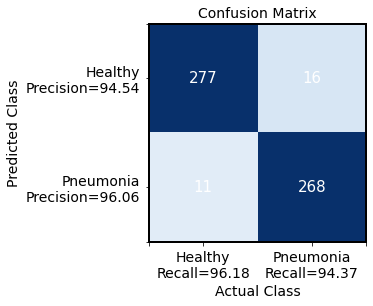

+ Printing ROC curve...



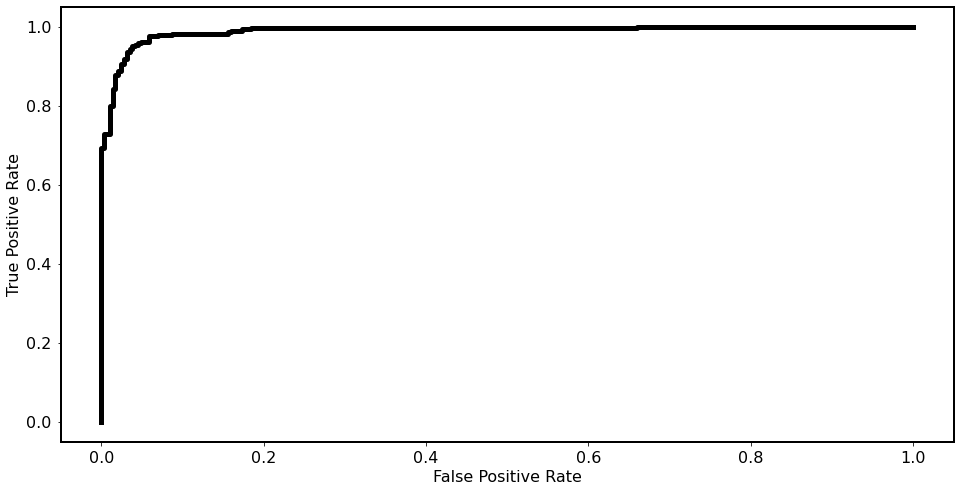

98.93

In [22]:
bestAcc = 0.0
bestEpoch = 0
bestAUC = 0
bestAccPredictions, bestAccPredictionProbabilities = [], []

print("+ Starting training. Each epoch can take about 2-5 minutes, hold tight!")
print("-----------------------------------------------------------------------\n")
for epoch in range(epochs):
    
    #################################################### Model Training ###############################################################
    if USE_DATA_AUGMENTATION == True:
        # Use data augmentation in alternate epochs
        if epoch % 2 == 0:
            # Alternate between training with and without augmented data. Training just on the augmented data might not be the best way to go.
            ############ You can change the "epoch % 2" to some other integer value to train on top of the augmented data 
            ############ after a certain number of epochs e.g "epoch % 3" will train on augmented data after every 2 epochs ############
            model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),
                        steps_per_epoch=len(trainData) / batchSize, epochs=1, verbose = 2)
        else:
            model.fit(trainData, trainLabels, batch_size=batchSize, epochs=1, verbose = 2)
    else:
        # Do not use data augmentation
        model.fit(trainData, trainLabels, batch_size=batchSize, epochs=1, verbose = 2)
    
    
    #################################################### Model Testing ###############################################################
    # Calculate test accuracy
    accuracy = round(model.evaluate(testData, testLabels)[1] * 100, 3)
    predictions = model.predict(testData)
    AccPredictionProbabilities = model.predict(testData)
    AccPredictions = [1 if item[1] > item[0] else 0 for item in AccPredictionProbabilities]
    epochAUC = calculateMetrics(AccPredictions, AccPredictionProbabilities, testLabels)
    print("+ Test accuracy at epoch %d is: %.2f " % (epoch, accuracy))
    print("+ Test AUC at epoch %d is: %.3f " % (epoch, epochAUC))
    outputFile = open("results/Log.txt", "a")
    outputFile.write("Epoch-Accuracy-AUC \t %d \t %.2f \t %.3f \n" % (epoch, accuracy,epochAUC))
    outputFile.close()
    
    if epochAUC > bestAUC:
        bestEpoch = epoch
        bestAcc = accuracy
        bestAUC = epochAUC
        bestAccPredictions = [1 if item[1] > item[0] else 0 for item in predictions]
        bestAccPredictionProbabilities = predictions
        
        ##################################### Store predictions for kaggle ###########################################################
        kaggleResultsFileName = "epoch-" + str(epoch) + "-results.csv"
        getKagglePredictions(model, kaggleTestImages, kaggleResultsFileName)
        ##############################################################################################################################
    print('\n')
print("------------------------------------------------------------------------")


##################################################### Printing best metrics ##########################################################
# Get more metrics for the best performing epoch
print("\n*** Printing our best validation results that we obtained in epoch %d ..." % bestEpoch)
calculateMetricsAndPrint(bestAccPredictions, bestAccPredictionProbabilities, testLabels)

## 4.4 Top n% Predictions

+ Accuracy for top 5 percent predictions for healthy: 100.00, pneumonia: 100.00
+ Accuracy for top 10 percent predictions for healthy: 100.00, pneumonia: 100.00
+ Accuracy for top 20 percent predictions for healthy: 99.12, pneumonia: 100.00
+ Accuracy for top 30 percent predictions for healthy: 99.41, pneumonia: 100.00


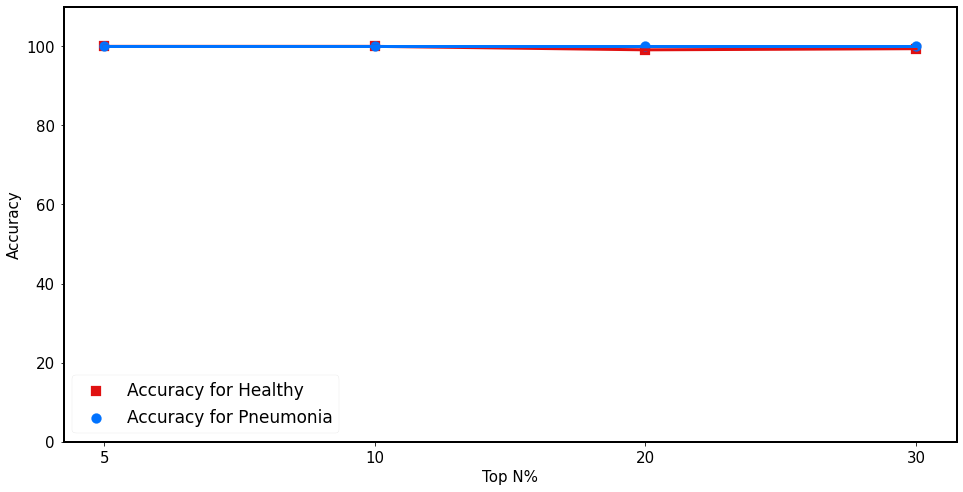

In [24]:
################################## You can change values inside the following list ###########################
topNValues = [5, 10, 20, 30]
##############################################################################################################

accuraciesHealthy, accuraciesPneumonia = [], []
for topn in topNValues:
    accuracyHealthy, accuracyPneumonia = calculateClasswiseTopNAccuracy(testLabels, bestAccPredictionProbabilities, topn)
    accuraciesHealthy.append(accuracyHealthy)
    accuraciesPneumonia.append(accuracyPneumonia)
    
    print("+ Accuracy for top %d percent predictions for healthy: %.2f, pneumonia: %.2f" % (topn, accuracyHealthy, accuracyPneumonia))
    
# Plot results
x = np.arange(len(accuraciesHealthy))
plt.plot(x, accuraciesHealthy, linewidth = 3, color = '#e01111')
scatterHealthy = plt.scatter(x, accuraciesHealthy, marker = 's', s = 100, color = '#e01111')
plt.plot(x, accuraciesPneumonia, linewidth = 3, color = '#0072ff')
scatterPneumonia = plt.scatter(x, accuraciesPneumonia, marker = 'o', s = 100, color = '#0072ff')
plt.xticks(x, topNValues, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Top N%", fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend([scatterHealthy, scatterPneumonia], ["Accuracy for Healthy", "Accuracy for Pneumonia"], fontsize = 17)
plt.ylim(0, 110)
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2da7edf6-dcd9-4d26-8af1-b990b67baf63' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>